In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [3]:
import warnings
warnings.simplefilter('ignore',FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
base_dir = '..\\data\\'

pickles = ['df_sj.pkl', 'df_iq.pkl',
           'sj_Xbayes.pkl', 'iq_Xbayes.pkl']

#read in prepocessed dataframes
with open(base_dir+pickles[0],'rb') as f:
    sj = pickle.load(f)

sj_Y = sj[['total_cases']]

with open(base_dir+pickles[1],'rb') as f:
    iq = pickle.load(f)
    
iq_Y = iq[['total_cases']]
    
with open(base_dir+pickles[2],'rb') as f:
    sj_X = pickle.load(f)
    
with open(base_dir+pickles[3],'rb') as f:
    iq_X = pickle.load(f)

## Preparation

In [5]:
# Removing the temporal features
iq_X_nodates = iq_X.drop(['weekofyear','year','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],axis=1)
sj_X_nodates = sj_X.drop(['weekofyear','year','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],axis=1)

In [6]:
# iq_X_nodates['ndvi'] = iq_X_nodates[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].sum(axis=1)
# iq_X_nodates= iq_X_nodates.drop(['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'], axis= 1)

# sj_X_nodates['ndvi'] = sj_X_nodates[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].sum(axis=1)
# sj_X_nodates= sj_X_nodates.drop(['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'], axis= 1)

In [8]:
iq_Xtrain, iq_Xtest, iq_Ytrain, iq_Ytest = train_test_split(iq_X_nodates, iq_Y, shuffle= False, test_size= 0.25)
sj_Xtrain, sj_Xtest, sj_Ytrain, sj_Ytest = train_test_split(sj_X_nodates, sj_Y, shuffle= False, test_size= 0.25)
print("IQ train size {}, IQ test size {}".format(iq_Xtrain.shape[0], iq_Xtest.shape[0]))
print("SJ train size {}, SJ test size {}".format(sj_Xtrain.shape[0], sj_Xtest.shape[0]))

IQ train size 390, IQ test size 130
SJ train size 702, SJ test size 234


## Preprocessing

#### Utility functions

In [9]:
# set random seed
np.random.seed(1)

# features to get the rolling window sum for, as standing water is important to the lifecycle of mosquitoes. 
#    This wouldn't be represented well by a rolling mean if there was a week of heavy rain, and dry weeks after
rolling_sum_features=[
    'precipitation_amt_mm',
    'reanalysis_sat_precip_amt_mm',
    'station_precip_mm']

# Features to get a rolling window average for. Rolling sum doesn't make sense for things like temperature, 
#    where the sum would be much higher than the city has ever seen.
rolling_avg_features=[
    'ndvi_ne',
    'ndvi_nw',
    'ndvi_se',
    'ndvi_sw',
    'reanalysis_min_air_temp_c',
    'reanalysis_max_air_temp_c',
    'reanalysis_dew_point_temp_c',
    'reanalysis_avg_temp_c',
    'reanalysis_air_temp_c',
    'station_min_temp_c',
    'station_max_temp_c',
    'station_diur_temp_rng_c',
    'station_avg_temp_c',
    'reanalysis_tdtr_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_relative_humidity_percent']

def roll_features(X):
    """Rolling window of features
        params:
            X: dataframe with columns in rolling_sum_features and rolling_avg_features"""
    df = X.copy()
    for f in rolling_sum_features:
        df['rolled_sum_'+ f] = df[f].rolling(3).sum()
        
    for f in rolling_avg_features:
        df['rolled_avg_'+ f] = df[f].rolling(3).mean()
        
    return df


def roll_cases(X, how='mean', window=3):
    """Rolling calculation for case numbers
        params:
            X: DataFrame of shape[:, 1] or flat numpy array
            how: method to use; {'mean', 'sum'}, default='mean'
            window: size of rolling window to use in calculation of 'how', default=3"""
    isdf = False
    if isinstance(X, pd.DataFrame):
        isdf = True
        x = X.to_numpy().ravel()
        idx = X.index
    else:
        x = X
        
    shape = x.shape[:-1] + (x.shape[-1] - window + 1, window)
    strides = x.strides + (x.strides[-1],)

    if how is 'mean':
         rolled = np.mean(np.lib.stride_tricks.as_strided(x, shape= shape, strides= strides), 1)
    elif how is 'sum':
        rolled =  np.sum(np.lib.stride_tricks.as_strided(x, shape= shape, strides= strides), 1)
        
    rolled = np.append([0,0], rolled)
    df = pd.DataFrame(rolled, columns= ['total_cases'])
    if isdf:
        df.index = idx
        
    return df


def rmsle(ytrue, ypred):
    y = ytrue.to_numpy() if isinstance(ytrue, pd.DataFrame) else ytrue
    return np.mean(np.sqrt((np.power(np.log1p(ypred) - np.log1p(y), 2))/(len(y))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


def smape(ytrue, ypred):
    """Symmetric Mean absolute percentage error"""
    true = ytrue.to_numpy().ravel() if isinstance(ytrue, pd.DataFrame) else ytrue
    
    smape_score = 1/len(true) * np.sum((np.abs(ypred - true)) / (np.abs(true) + np.abs(ypred)))
    return smape_score


def getscores(ytrue, ypred, log=False):
    """Print RMSE, MAE, SMAPE, R^2 scores"""
    scores = {}
    scores['MAE'] = mean_absolute_error(ytrue, ypred)
    scores['SMAPE'] = smape(ytrue, ypred)
    if log is False:
        scores['RMSE'] = mean_squared_error(ytrue, ypred, squared= False) 
    else:
        scores['RMSLE'] = rmsle(ytrue, ypred)
        
    return scores

In [10]:
###  Decided not to go with these features and functions:
###  getWeekAvgDict: Didn't go with this because I wanted to use climate and geographic data to predict outbreaks
###  >> instead of prediciting non-outbreak case numbers

###  get_pct_change: eliminated this because it relies on only predicting a small number of weeks in advance.
###  >> In production, this may not be feasable or realistic - depending on the application. 

#  Both of these features improve our model performance, leaving them here if goal of models changes.

def getWeekAvgDict(y):
    """Get dict of average number of cases by week of year
    params:
        y: DataFrame or series with DateTimeIndex """
    return y.groupby(y.index.weekofyear).mean().total_cases.to_dict()


def get_pct_change(y):
    """Get the percent change of the case numbers   
      params:
        y: DataFrame of total cases with shape [:, 1]"""
    change_last_week = y.total_cases.shift(3).pct_change()

  # Due to shifting and pct_change First valid index is inf or a valid value, everything before is NaN
    change_last_week.loc[:change_last_week.first_valid_index()].fillna(0, inplace= True) 

    while np.isinf(change_last_week).any() or np.isnan(change_last_week).any():
     #get index of nan values
        nan_index = np.where(np.isnan(change_last_week))[0]

     # get the average percent change from the past weeks
        nan_fix = [np.mean(change_last_week[i-2: i]) for i in nan_index]
        change_last_week[nan_index] = nan_fix

     # get index of inf values
        inf_index = np.where(np.isinf(change_last_week))[0]    
        inf_fix = [np.mean(change_last_week[j-2: j]) for j in inf_index]
        change_last_week[inf_index] = inf_fix

    return change_last_week

In [11]:
# Prediction model for the bulk of this notebook for a walk forward approach
def steptesting(Xtrain, Ytrain, Xtest, Ytest , estimator):
    """Get model predictions in a step wise fashion 3 weeks at a time, refitting the model
    after each iteration of perdictions to provide a better fit"""
    xtest = Xtest.copy()
    _Xtraintest = Xtrain.copy()
    
    ytest = Ytest.copy()
    _Ytraintest = Ytrain.copy()
    
    predictions = []
    model =  estimator
    
    while ytest.size >=1:
        # get the next batch of rows to predict on, 3 week forecast window
        curr_testsetX = xtest[:3]
        curr_testsetY = ytest[:3]
        
        # reduce the Xtest and ytest dataframes
        xtest = xtest[3:]
        ytest = ytest[3:]
        
        # we don't know the percent change for next 3 weeks, but we guess based on last known value
        if 'percent_change' in _Xtraintest:
            if _Ytraintest.total_cases[-2] != 0:
                pct = (_Ytraintest.total_cases[-1] / _Ytraintest.total_cases[-2])-1
                curr_testsetX.iloc[0]['percent_change'] = pct
            if curr_testsetX.shape[0] > 1:
                  # The distribution is non-normal, powerlognorm seemed to give good results from what I've tested, but no difference in predictions
                curr_testsetX.iloc[1:]['percent_change'] = [np.random.normal(pct) for i in range(curr_testsetX.shape[0]-1)] 

        if 'prev_weeks' in _Xtraintest:
            curr_testsetX['prev_weeks'] = _Ytraintest.total_cases[-curr_testsetX.shape[0]:].values
    
        # fit the model to the training data
        model.fit(_Xtraintest, _Ytraintest.to_numpy().ravel())
        
        #make predictions
        yhat = model.predict(curr_testsetX)
        predictions = np.append(predictions, yhat)

        #calculate percent change
        if 'percent_change' in _Xtraintest:
            _Xtraintest['percent_change'] = get_pct_change(_Ytraintest) #reduncent for known values
        
         #Update the average case numbers per week
        if 'week_avg_cases' in _Xtraintest:
            avg_dict = getWeekAvgDict(_Ytraintest)
            _Xtraintest['week_avg_cases'] = _Xtraintest.index.weekofyear.map(avg_dict).values
            xtest['week_avg_cases'] = xtest.index.weekofyear.map(avg_dict).values        
        
        #append the curr_testsetX and curr_testsetY to _Xtraintest, _Ytraintset DFs
        _Xtraintest = _Xtraintest.append(curr_testsetX)
        _Ytraintest = _Ytraintest.append(curr_testsetY)
        
    return predictions

In [12]:
# Training
# Get 3 week rolling values
iq_XtrainRolled = roll_features(iq_Xtrain).fillna(method = 'bfill')
sj_XtrainRolled = roll_features(sj_Xtrain).fillna(method = 'bfill')

# Testing
iq_XtestRolled = roll_features(iq_Xtest).fillna(method = 'bfill')
sj_XtestRolled = roll_features(sj_Xtest).fillna(method = 'bfill')

In [13]:
tscv = TimeSeriesSplit(10)

In [13]:
# Greatly improves prediction performace but these are features of the target variable, don't seem appropriate to use when trying to predict the target variable
# >> Must use with the steptesting function when predicitng

### # Get percent change from 3 weeks ago to last week
# iq_XtrainRolled['percent_change'] = get_pct_change(iq_Ytrain)
# Get 3 week lag case numbers
# iq_XtrainRolled['prev_weeks'] = iq_Ytrain.shift(3).fillna(0)
# Get the weekly average number of cases for each week of year
# iq_XtrainRolled['week_avg_cases'] = iq_Ytrain.groupby(iq_Ytrain.index.weekofyear).transform('mean')
# sj_XtrainRolled['percent_change'] = get_pct_change(sj_Ytrain)
# sj_XtrainRolled['prev_weeks'] = sj_Ytrain.shift(3).fillna(0)
# sj_XtrainRolled['week_avg_cases'] = sj_Ytrain.groupby(sj_Ytrain.index.weekofyear).transform('mean')

### # We don't know these values since they are based off of the case numbers in the testing set, 
### # >> so initialize to 0
# iq_XtestRolled['percent_change'] = 0.0
# iq_XtestRolled['prev_weeks'] = 0.0
### # same process as the X train set, but we are using the "known" case number weekly averages based on Y train
# iq_XtestRolled['week_avg_cases'] = iq_XtestRolled.index.weekofyear.map(getWeekAvgDict(iq_Ytrain)).values
# sj_XtestRolled['percent_change'] = 0.0
# sj_XtestRolled['prev_weeks'] = 0.0
# sj_XtestRolled['week_avg_cases'] = sj_XtestRolled.index.weekofyear.map(getWeekAvgDict(sj_Ytrain)).values

In [15]:
# Try modeling off of the residuals of a simple OLS
# >> Ridge, Lasso, ElasticNet predict about the mean of entire testing set, don't help with later models

# from sklearn.linear_models import LinearRegression, Ridge, Lasso, ElasticNet
# iq_lr = LinearRegression()
# iq_lr.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# iq_lr_pred = iq_lr.predict(iq_XtestRolled)

# iq_ridge = Ridge()
# iq_ridge.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
# iq_ridge_pred = iq_ridge.predict(iq_XtestRolled)

# iq_lasso = Lasso()
# iq_lasso.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
# iq_lasso_pred = iq_lasso.predict(iq_XtestRolled)

# iq_elastic = ElasticNet()
# iq_elastic.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
# iq_elastic_pred = iq_elastic.predict(iq_XtestRolled)

# # SJ
# sj_lr = LinearRegression()
# sj_lr.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# sj_lr_pred = sj_lr.predict(iq_XtestRolled)

In [16]:
# Modeling using the variance of the target variables
# iq_var = ((iq_Ytrain - iq_Ytrain.mean())**2)
# sj_var = ((sj_Ytrain - sj_Ytrain.mean())**2)

In [17]:
# Transforming the target variables, sqrt/log

# iq_ytrain_log = np.log(iq_Ytrain).replace(-np.inf, 0)
# iq_ytest_log = np.log(iq_Ytest).replace(-np.inf, 0)

In [18]:
# ExtraTreesRegressor predictions stick around the mean for Iquitos and predict higher cases but not usefully for San Juan

In [19]:
# SVR also stays around the mean, different parameters and kernels don't seem to change predictions much

In [ ]:
# including the month dummy variables and leaving NDVI Veg index as 4 quadrants rather than combinining into one 
# results in a flatter prediction, or "flat spots" in the predicitons.

# GradientBoostingReg

### Iquitos

In [328]:
# Trying the GradientBoosting with rolled target cases avg, w=3
# iq_Yrolled = roll_cases(iq_Ytrain)
# sj_Yrolled = roll_cases(sj_Ytrain)
# iq_rolled_sqrt_weight = np.sqrt(iq_Yrolled) + 0.01
# sj_rolled_sqrt_weight = np.sqrt(sj_Yrolled) + 0.01

In [32]:
# Some different sample weights
iq_ytrain_sqrt = np.sqrt(iq_Ytrain)
iq_ytrain_sqrt_weight = iq_ytrain_sqrt + 0.1
sj_ytrain_sqrt = np.sqrt(sj_Ytrain)
sj_ytrain_sqrt_weight = sj_ytrain_sqrt + 0.1

In [16]:
# iq_gbr_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                   'n_estimators': range(100, 1001, 100)}

# iq_gbr = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(iq_gbr, iq_gbr_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1)
# gs.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

In [465]:
iq_testroll = roll_cases(iq_Ytest, how='mean')
sj_testroll = roll_cases(sj_Ytest, how= 'mean')

{'MAE': 8.143143444628821,
 'SMAPE': 0.44412204310148756,
 'RMSE': 13.023045341051033}

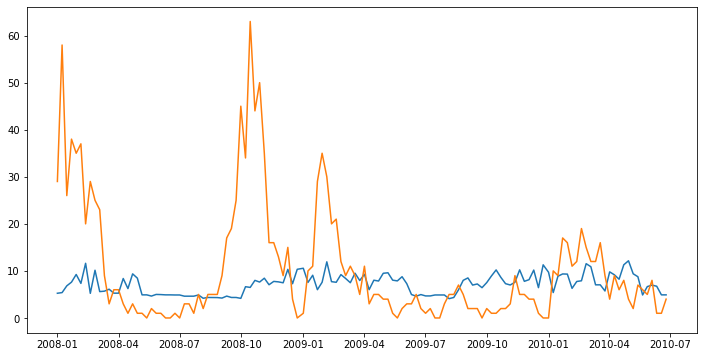

In [59]:
iq_gbr_grid = {'learning_rate': 0.01, 'n_estimators': 100}

iq_gbr = GradientBoostingRegressor(random_state= 1, **iq_gbr_grid)
iq_gbr.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
iq_gbr_pred = iq_gbr.predict(iq_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_gbr_pred)
plt.plot(iq_Ytest)
display(getscores(iq_Ytest, iq_gbr_pred))
# IQ did better when fitting without sample weights(sqrt + 0.01), fitting with sample weight not squared is worse. -> conclusion, don't fit with sample weights for rolled Y
# fitting on weekly Y, no better than rolled. when applying sample weights-> worse of all tested

In [20]:
# SJ
# sj_gbr_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                'n_estimators': range(100, 1001, 100)}

# sj_gbr = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(sj_gbr, sj_gbr_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1).fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

{'MAE': 25.48891012728875,
 'SMAPE': 0.48078072855944387,
 'RMSE': 30.484686816828752}

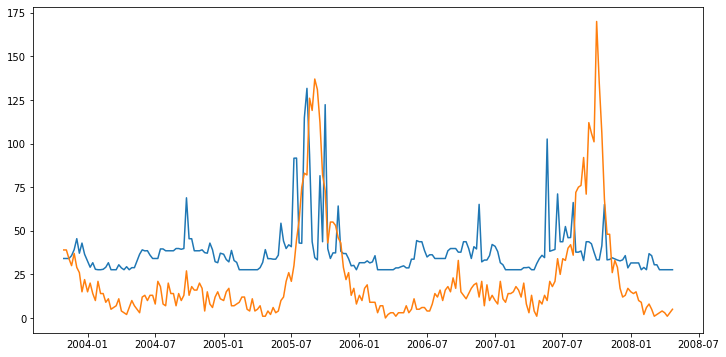

In [46]:
# weekly no weights
sj_gbr_grid = {'learning_rate': 0.01, 'n_estimators': 100}

sj_gbr = GradientBoostingRegressor(random_state = 1, **sj_gbr_grid)
sj_gbr.fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
sj_gbr_pred = sj_gbr.predict(sj_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_gbr_pred)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_gbr_pred)

Very different results from both cities as seen in all models tested. Iquitos seems to be struggle learning the pattern in case numbers while San Juan overpredicts and seems very volatile

## RFE

In [20]:
# i = RFECV(iq_gbr, cv= tscv, scoring= rmsle_scorer, n_jobs= -1).fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# iq_gbr_RFEfeats = iq_XtrainRolled.columns[i.get_support()]
# iq_gbr_RFEfeats

In [18]:
iq_gbr_RFEfeats = ['reanalysis_specific_humidity_g_per_kg', 
                   'reanalysis_tdtr_k',
                   'reanalysis_max_air_temp_c',
                   'reanalysis_min_air_temp_c',
                   'rolled_sum_precipitation_amt_mm',
                   'rolled_sum_reanalysis_sat_precip_amt_mm', 
                   'rolled_avg_ndvi_se',
                   'rolled_avg_ndvi_sw',
                   'rolled_avg_reanalysis_min_air_temp_c',
                   'rolled_avg_reanalysis_dew_point_temp_c',
                   'rolled_avg_station_min_temp_c',
                   'rolled_avg_station_max_temp_c',
                   'rolled_avg_station_diur_temp_rng_c',
                   'rolled_avg_station_avg_temp_c',
                   'rolled_avg_reanalysis_tdtr_k']

In [29]:
# iq_gbr_feat_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                   'n_estimators': np.arange(100, 1001, 100)}

# iq_gbr_feat = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(iq_gbr_feat, iq_gbr_feat_grid, cv= tscv, scoring= rmsle_scorer, n_jobs= -1)
# gs.fit(iq_XtrainRolled[iq_gbr_RFEfeats], iq_Ytrain.values.ravel())
# gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

{'MAE': 8.15371597733526,
 'SMAPE': 0.4455324306141187,
 'RMSE': 13.054631711386053}

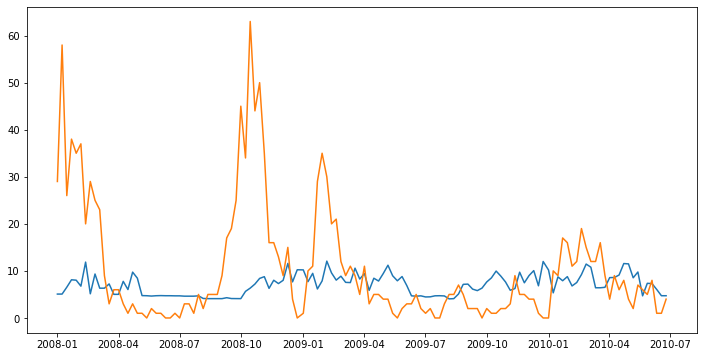

In [37]:
iq_gbr_feat_grid = {'learning_rate': 0.01, 'n_estimators': 100}
iq_gbr_feat = GradientBoostingRegressor(random_state= 1, **iq_gbr_feat_grid)
iq_gbr_feat.fit(iq_XtrainRolled[iq_gbr_RFEfeats], iq_Ytrain.values.ravel())
iq_gbr_feat_pred = iq_gbr_feat.predict(iq_XtestRolled[iq_gbr_RFEfeats])

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_gbr_feat_pred)
plt.plot(iq_Ytest)
getscores(iq_Ytest, iq_gbr_feat_pred)
# Slightly worse performace than using all features for Iquitos

In [ ]:
# Step testing with Iquitos RFE features
# >> statistically worse than the full prediction, we see overpredicting on many weeks. No better on outbreaks
i_st = steptesting(iq_XtrainRolled[iq_gbr_RFEfeats], iq_Ytrain, iq_XtestRolled[iq_gbr_RFEfeats], iq_Ytest, iq_gbr_feat)

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, i_st)
plt.plot(iq_Ytest)
getscores(iq_Ytest, i_st)
# Statistically slightly better but empirically, I argue its worse

In [40]:
# s = RFECV(sj_gbr, cv= tscv, scoring= rmsle_scorer, n_jobs= -1).fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# sj_gbr_RFEfeats = sj_XtrainRolled.columns[s.get_support()]
# sj_gbr_RFEfeats

In [22]:
sj_gbr_RFEfeats= ['ndvi_nw', 
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_relative_humidity_percent',
                  'station_max_temp_c',
                  'reanalysis_dew_point_temp_c',
                  'rolled_avg_ndvi_ne',
                  'rolled_avg_ndvi_se',
                  'rolled_avg_reanalysis_dew_point_temp_c',
                  'rolled_avg_station_min_temp_c',
                  'rolled_avg_station_max_temp_c',
                  'rolled_avg_station_diur_temp_rng_c',
                  'rolled_avg_reanalysis_tdtr_k',
                  'rolled_avg_reanalysis_specific_humidity_g_per_kg',
                  'rolled_avg_reanalysis_relative_humidity_percent']

In [50]:
# sj_rfe_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#               'n_estimators': range(100, 1001, 100)}

# sj_gbr_rfe = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(sj_gbr_rfe, sj_rfe_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1)
# gs.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain.values.ravel())
# gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

{'MAE': 25.41783161604617,
 'SMAPE': 0.4791594503410759,
 'RMSE': 30.649102911213088}

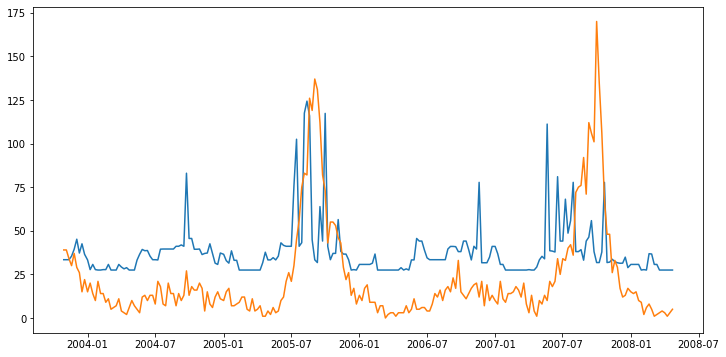

In [39]:
sj_rfe_grid = {'learning_rate': 0.01, 'n_estimators': 100}
sj_gbr_rfe = GradientBoostingRegressor(random_state= 1, **sj_rfe_grid)
sj_gbr_rfe.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain.values.ravel())
sj_gbr_rfe_pred = sj_gbr_rfe.predict(sj_XtestRolled[sj_gbr_RFEfeats])

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_gbr_rfe_pred)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_gbr_rfe_pred)

{'MAE': 23.290914673623156,
 'SMAPE': 0.45921448377113383,
 'RMSE': 29.44147837981424}

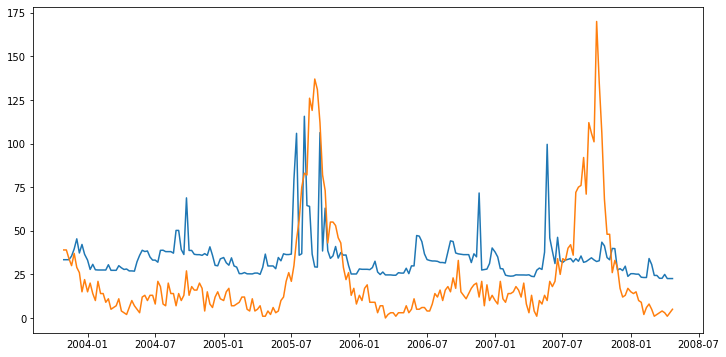

In [40]:
s = steptesting(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain, sj_XtestRolled[sj_gbr_RFEfeats], sj_Ytest, sj_gbr_rfe)

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, s)
plt.plot(sj_Ytest)
getscores(sj_Ytest, s)

# XGBoost

In [27]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [48]:
xgbR_grid = {
    "n_estimators": stats.randint(3, 400),
    "max_depth": stats.randint(3, 40),
    "learning_rate": stats.uniform(0.01, 0.1),
    "colsample_bytree": stats.beta(10, 1),
    "subsample": stats.beta(10, 1),
    "gamma": stats.uniform(0, 10),
    'reg_alpha': stats.expon(0, 50),
    "min_child_weight": stats.expon(0, 50)}

# # IQ
# iq_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1)  
# rsx.fit(iq_XtrainRolled, iq_Ytrain)  
# rsx.best_params_

{'MAE': 7.975504611088679,
 'SMAPE': 0.4547962870492383,
 'RMSE': 13.731485467596698}

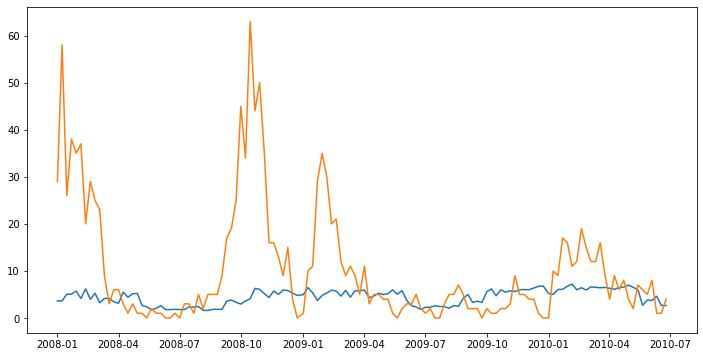

In [41]:
iq_xg_grid = {'colsample_bytree': 0.9987547245408968,
 'gamma': 5.38627282576347,
 'learning_rate': 0.010301795661959637,
 'max_depth': 24,
 'min_child_weight': 74.85339251647828,
 'n_estimators': 95,
 'reg_alpha': 79.47366244819447,
 'subsample': 0.9855218877187018}

iq_xgr = XGBRegressor(random_state= 1, **iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled, iq_Ytrain) 
iq_x_pred = iq_xgr.predict(iq_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_x_pred)
plt.plot(iq_Ytest)
getscores(iq_Ytest, iq_x_pred)

In [908]:
# play
# iq_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(iq_XtrainRolled, iq_Ytrain)
# rsx.best_params_

{'MAE': 7.920835269414462,
 'SMAPE': 0.4316775816459188,
 'RMSE': 12.955776959818044}

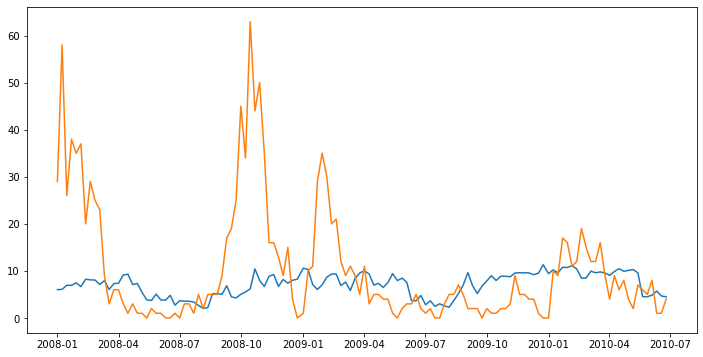

In [61]:
# IQ regular fit/predict, GridSearch with rmsle_solver
iq_xg_grid = {'colsample_bytree': 0.9946533822621874,
 'gamma': 5.316681065960522,
 'learning_rate': 0.02301947207891894,
 'max_depth': 19,
 'min_child_weight': 182.1037590780387,
 'n_estimators': 240,
 'reg_alpha': 11.067875388692595,
 'subsample': 0.9510831261414849}

iq_xgr = XGBRegressor(random_state= 1, **iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled, iq_Ytrain) 
iq_x_pred = iq_xgr.predict(iq_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_x_pred)
plt.plot(iq_Ytest)
display(getscores(iq_Ytest, iq_x_pred))

Ffeature subset the important features from XGBoost Iquitos

In [68]:
i_notzero = iq_xgr.feature_importances_ != 0.
iq_xg_imp_feats = iq_XtrainRolled.columns[i_notzero]
# iq_xg_imp_feats

In [67]:
# # play with feature importance features, regular
# iq_xgr_imp = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr_imp, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(iq_XtrainRolled[iq_xg_imp_feats], iq_Ytrain)
# rsx.best_params_

{'MAE': 7.915163453725668,
 'SMAPE': 0.4320545519865555,
 'RMSE': 12.95186980412542}

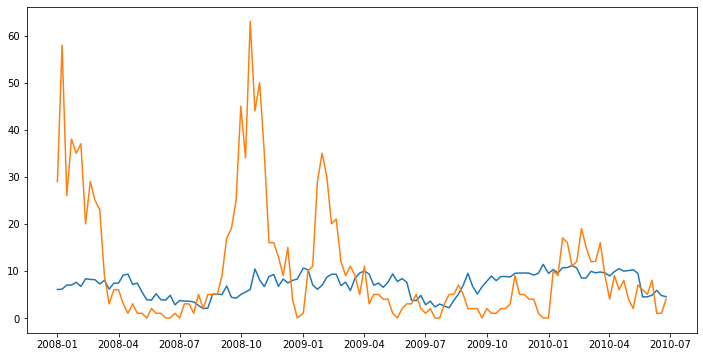

In [66]:
iq_xg_imp_grid = {'colsample_bytree': 0.9946533822621874,
 'gamma': 5.316681065960522,
 'learning_rate': 0.02301947207891894,
 'max_depth': 19,
 'min_child_weight': 182.1037590780387,
 'n_estimators': 240,
 'reg_alpha': 11.067875388692595,
 'subsample': 0.9510831261414849}

iq_xgr_imp = XGBRegressor(random_state= 1, **iq_xg_imp_grid)
iq_xgr_imp.fit(iq_XtrainRolled[iq_xg_imp_feats], iq_Ytrain) 
iq_x_imp_pred = iq_xgr_imp.predict(iq_XtestRolled[iq_xg_imp_feats])

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_x_imp_pred)
plt.plot(iq_Ytest)
getscores(iq_Ytest, iq_x_imp_pred)

In [907]:
# play with RFE features, regular
# iq_xgr = XGBRegressor( random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(iq_XtrainRolled[iq_gbr_RFEfeats], iq_Ytrain)
# rsx.best_params_

{'MAE': 8.022862736995403,
 'SMAPE': 0.4306916621647801,
 'RMSE': 13.054529048404264}

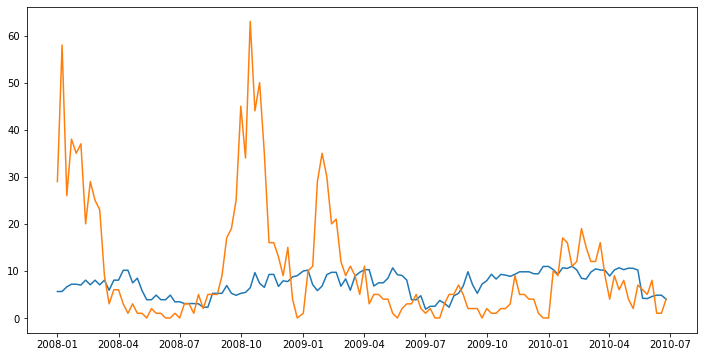

In [43]:
# play  with RFE features, regular
iq_xg_grid = {'colsample_bytree': 0.9946533822621874,
 'gamma': 5.316681065960522,
 'learning_rate': 0.02301947207891894,
 'max_depth': 19,
 'min_child_weight': 182.1037590780387,
 'n_estimators': 240,
 'reg_alpha': 11.067875388692595,
 'subsample': 0.9510831261414849}

iq_xgr = XGBRegressor(random_state= 1, **iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled[iq_gbr_RFEfeats], iq_Ytrain) 
iq_x_pred = iq_xgr.predict(iq_XtestRolled[iq_gbr_RFEfeats])

plt.figure(figsize= (12,6))
plt.plot(iq_Ytest.index, iq_x_pred)
plt.plot(iq_Ytest)
getscores(iq_Ytest, iq_x_pred)

In [49]:
# sj_xgr_reg = XGBRegressor(random_state= 1)
# rsx_reg = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1)  
# rsx_reg.fit(sj_XtrainRolled, sj_Ytrain)
# rsx_reg.best_params_

{'colsample_bytree': 0.8315424531606493,
 'gamma': 2.035103210479494,
 'learning_rate': 0.010800271065209957,
 'max_depth': 24,
 'min_child_weight': 33.275692814640365,
 'n_estimators': 47,
 'reg_alpha': 39.87517908198642,
 'subsample': 0.8320070378722152}

{'MAE': 14.820160949332083,
 'SMAPE': 0.32124372081925456,
 'RMSE': 29.104776050410855}

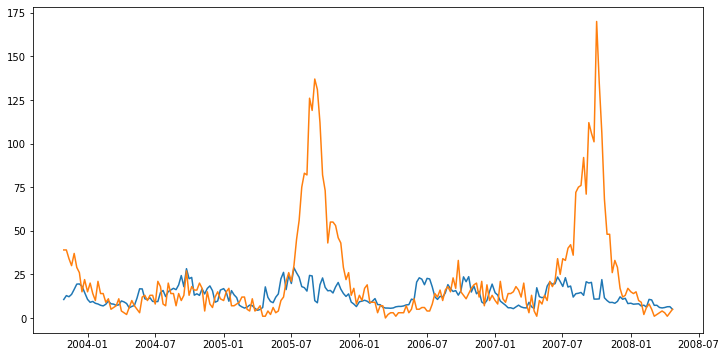

In [50]:
sj_xgr_reg_grid = {'colsample_bytree': 0.8315424531606493,
 'gamma': 2.035103210479494,
 'learning_rate': 0.010800271065209957,
 'max_depth': 24,
 'min_child_weight': 33.275692814640365,
 'n_estimators': 47,
 'reg_alpha': 39.87517908198642,
 'subsample': 0.8320070378722152}

sj_xgr_reg = XGBRegressor(**sj_xgr_reg_grid, random_state= 1)
sj_xgr_reg.fit(sj_XtrainRolled, sj_Ytrain)
sj_xgr_reg_pred = sj_xgr_reg.predict(sj_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_xgr_reg_pred)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_xgr_reg_pred)

In [906]:
# sj_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(sj_XtrainRolled, sj_Ytrain, sample_weight= sj_ytrain_sqrt_weight)
# rsx.best_params_

{'MAE': 14.558449510835175,
 'SMAPE': 0.31065621148705536,
 'RMSE': 27.087403536771333}

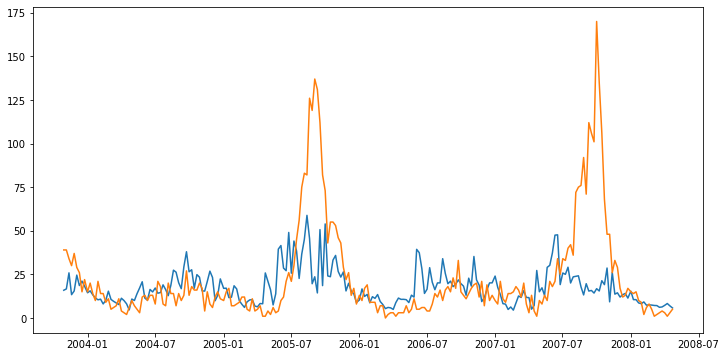

In [69]:
sj_xg_grid = {'colsample_bytree': 0.8315424531606493,
 'gamma': 2.035103210479494,
 'learning_rate': 0.010800271065209957,
 'max_depth': 24,
 'min_child_weight': 33.275692814640365,
 'n_estimators': 47,
 'reg_alpha': 39.87517908198642,
 'subsample': 0.8320070378722152}

sj_xgr = XGBRegressor(**sj_xg_grid)
sj_xgr.fit(sj_XtrainRolled, sj_Ytrain, sample_weight=  sj_ytrain_sqrt_weight)
sj_x_pred = sj_xgr.predict(sj_XtestRolled)

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_x_pred)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_x_pred)

The San Juan model isn't overpredicting now. It seems to be doing a better job at the weeks with lower case numbers but is now underpredicting for the weeks of outbreaks.

In [53]:
# rmsle solver, RFE subset SJ, without sample weights
sj_xgr_reg_RFE = XGBRegressor( random_state= 1)
rsx_ = RandomizedSearchCV(sj_xgr_reg_RFE, xgbR_grid, cv= tscv, 
                         n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
rsx_.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain)
rsx_.best_params_

{'colsample_bytree': 0.9987547245408968,
 'gamma': 5.38627282576347,
 'learning_rate': 0.010301795661959637,
 'max_depth': 24,
 'min_child_weight': 74.85339251647828,
 'n_estimators': 95,
 'reg_alpha': 79.47366244819447,
 'subsample': 0.9855218877187018}

{'MAE': 15.529963419987606,
 'SMAPE': 0.33408926708836795,
 'RMSE': 27.607154512860863}

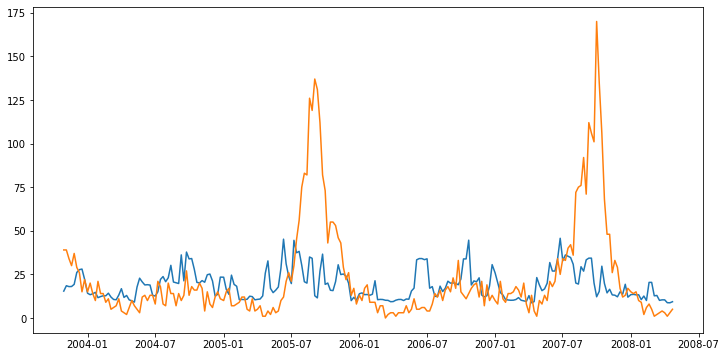

In [54]:
# rmsle solver, RFE subset SJ, without sample weights
sj_xgr_regRFE_grid = {'colsample_bytree': 0.9987547245408968,
 'gamma': 5.38627282576347,
 'learning_rate': 0.010301795661959637,
 'max_depth': 24,
 'min_child_weight': 74.85339251647828,
 'n_estimators': 95,
 'reg_alpha': 79.47366244819447,
 'subsample': 0.9855218877187018}

sj_ = XGBRegressor(**sj_xgr_regRFE_grid, random_state= 1)
sj_.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain)
sj_pred_ = sj_.predict(sj_XtestRolled[sj_gbr_RFEfeats])

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_pred_)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_pred_)

In [923]:
#  with RFE features, rmsle_scorer, with sample weights
# sj_xgr = XGBRegressor( random_state= 1)
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain, sample_weight= sj_ytrain_sqrt)
# rsx.best_params_

{'MAE': 15.04467841091319,
 'SMAPE': 0.32920866270636434,
 'RMSE': 26.71964399758178}

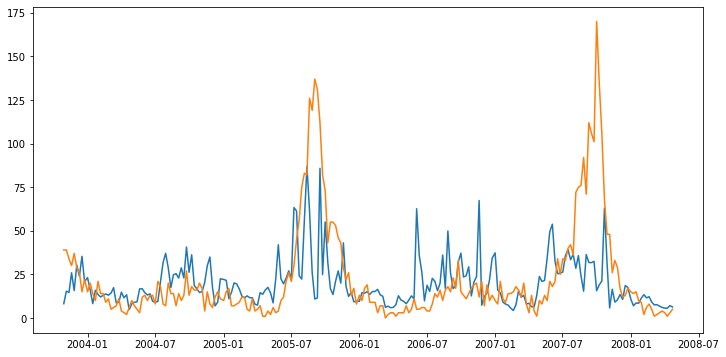

In [45]:
#  with RFE features, rmsle_scorer, with sample weights
sj_xg_grid = {'colsample_bytree': 0.914468120024053,
 'gamma': 1.934605692727246,
 'learning_rate': 0.01684310604015972,
 'max_depth': 36,
 'min_child_weight': 23.534980222443657,
 'n_estimators': 42,
 'reg_alpha': 46.377697099165474,
 'subsample': 0.9328069666508334}

sj_xgr = XGBRegressor(random_state= 1, **sj_xg_grid)
sj_xgr.fit(sj_XtrainRolled[sj_gbr_RFEfeats], sj_Ytrain, sample_weight=  sj_ytrain_sqrt)
sj_x_pred = sj_xgr.predict(sj_XtestRolled[sj_gbr_RFEfeats])

plt.figure(figsize= (12,6))
plt.plot(sj_Ytest.index, sj_x_pred)
plt.plot(sj_Ytest)
getscores(sj_Ytest, sj_x_pred)

Modeling off of the RFE selected features, we see a an increase in predicted values for almost all the weeks- to the point of overpredicting - but still not accurately predicting for the outbreak weeks. It seems we are losing accuracy in the predictions for the lower case number weeks and not gaining all too much for the outbreak weeks. The second outbreak period is still proving difficult to predict for.

# END Current progress

In [20]:
# Quantile predict GBR
alpha = 0.9

iq_gbr_grid = {'learning_rate': 0.1,
               'n_estimators': 250}

iq_gbr = GradientBoostingRegressor(loss= 'quantile', alpha= alpha, random_state= 1, **iq_gbr_grid)
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel())
y_upper = iq_gbr.predict(iq_XtestRolled)

iq_gbr.set_params(alpha= 1.- alpha)
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel())
y_lower= iq_gbr.predict(iq_XtestRolled)

iq_gbr.set_params(loss= 'ls')      
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel())
yhat = iq_gbr.predict(iq_XtestRolled)

In [21]:
# small epsilon for when target values are 0, don't want the model to ignore these weeks
# iq_ytrain_weight = iq_Ytrain + 0.1 
iq_ytrain_sqrt = np.sqrt(iq_Ytrain)
iq_ytrain_sqrt_weight = iq_ytrain_sqrt + 0.1

sj_ytrain_sqrt = np.sqrt(sj_Ytrain)
sj_ytrain_sqrt_weight = sj_ytrain_sqrt + 0.1

In [22]:
# iq_gbr_grid = {'learning_rate': [0.01, 0.1],
#               'n_estimators': np.arange(100, 501, 100),
#               'min_weight_fraction_leaf': np.arange(0.1, 0.6, 0.1)}

# iq_gbr_search = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(iq_gbr_search, iq_gbr_grid, cv= tscv, scoring= 'neg_mean_absolute_error', n_jobs= -1)
# gs.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel(), sample_weight= iq_ytrain_sqrt_weight.values.ravel())
# gs.best_params_

In [23]:
alpha = 0.9
iq_gbr_grid = {'learning_rate': 0.01, 
               'n_estimators': 500, 
               'min_weight_fraction_leaf': 0.1}

iq_gbr = GradientBoostingRegressor(loss= 'quantile', alpha= alpha, random_state= 1, **iq_gbr_grid)
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel(), sample_weight= iq_ytrain_sqrt_weight.values.ravel())
y_upper = iq_gbr.predict(iq_XtestRolled) **2

iq_gbr.set_params(alpha= 1.- alpha)
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel(), sample_weight= iq_ytrain_sqrt_weight.values.ravel())
y_lower= iq_gbr.predict(iq_XtestRolled) **2

iq_gbr.set_params(loss= 'ls')      
iq_gbr.fit(iq_XtrainRolled, iq_ytrain_sqrt.values.ravel(), sample_weight= iq_ytrain_sqrt_weight.values.ravel())
yhat = iq_gbr.predict(iq_XtestRolled) **2
# the steptesting funciton does slightly better but slower and less reliable as the number of weeks perdicting for increases

{'MAE': 8.972363683970901,
 'SMAPE': 0.46592979843393656,
 'RMSE': 13.172164655177713}

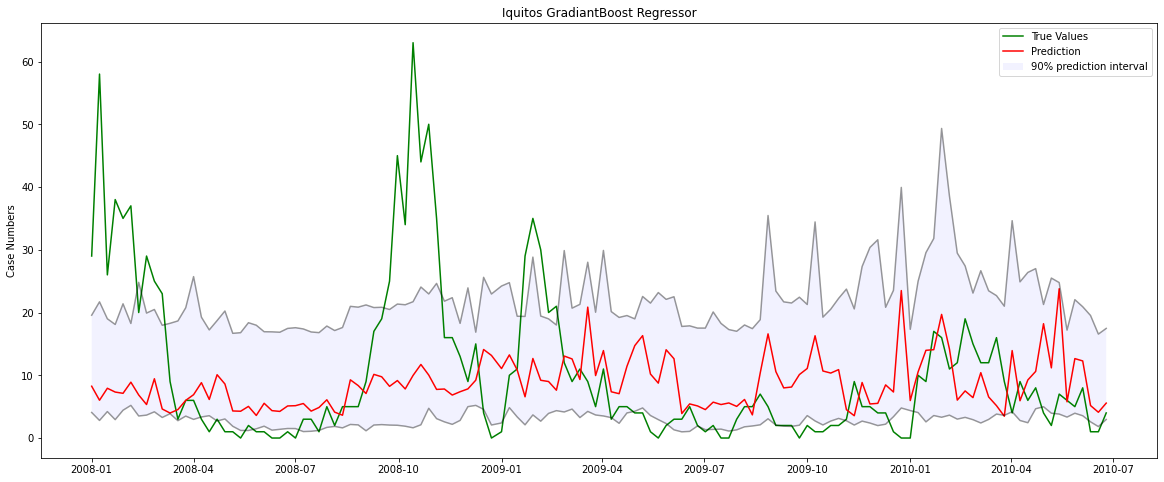

In [24]:
fig = plt.figure(figsize=(20, 8))
plt.plot(iq_Ytest, 'g-', label= 'True Values')
plt.plot(iq_Ytest.index, yhat, 'r-', label='Prediction')
plt.plot(iq_Ytest.index, y_upper, 'k-', alpha= 0.4)
plt.plot(iq_Ytest.index, y_lower, 'k-', alpha= 0.4)
plt.fill_between(iq_Ytest.index, y_lower, y_upper, alpha=.05, fc='b', label='90% prediction interval')
plt.ylabel('Case Numbers')
plt.title('Iquitos GradiantBoost Regressor')
plt.legend()
getscores(iq_Ytest, yhat)

### San Juan

In [25]:
# sj_gbr_grid = {'learning_rate': np.arange(0.1, 0.31, 0.1),
#               'n_estimators': np.arange(900, 2001, 100),
#               'min_weight_fraction_leaf': [0.01, 0.1]}

# sj_gbr_search = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(sj_gbr_search, sj_gbr_grid, cv= tscv, scoring= 'neg_mean_absolute_error', n_jobs= -1)
# gs.fit(sj_XtrainRolled, sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
# gs.best_params_

In [26]:
sj_gbr_grid = {'learning_rate': 0.1, 
               'min_weight_fraction_leaf': 0.01, 
               'n_estimators': 2000}

sj_gbr = GradientBoostingRegressor(loss= 'quantile', alpha= alpha,  random_state= 1, **sj_gbr_grid)
sj_gbr.fit(sj_XtrainRolled, sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
y_upper = sj_gbr.predict(sj_XtestRolled) **2

sj_gbr.set_params(alpha = 1. - alpha)
sj_gbr.fit(sj_XtrainRolled, sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
y_lower = sj_gbr.predict(sj_XtestRolled)**2

sj_gbr.set_params(loss= 'ls')
sj_gbr.fit(sj_XtrainRolled, sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
yhat = sj_gbr.predict(sj_XtestRolled)**2

{'MAE': 20.46708329439758,
 'SMAPE': 0.40908397982412154,
 'RMSE': 31.6234861400457}

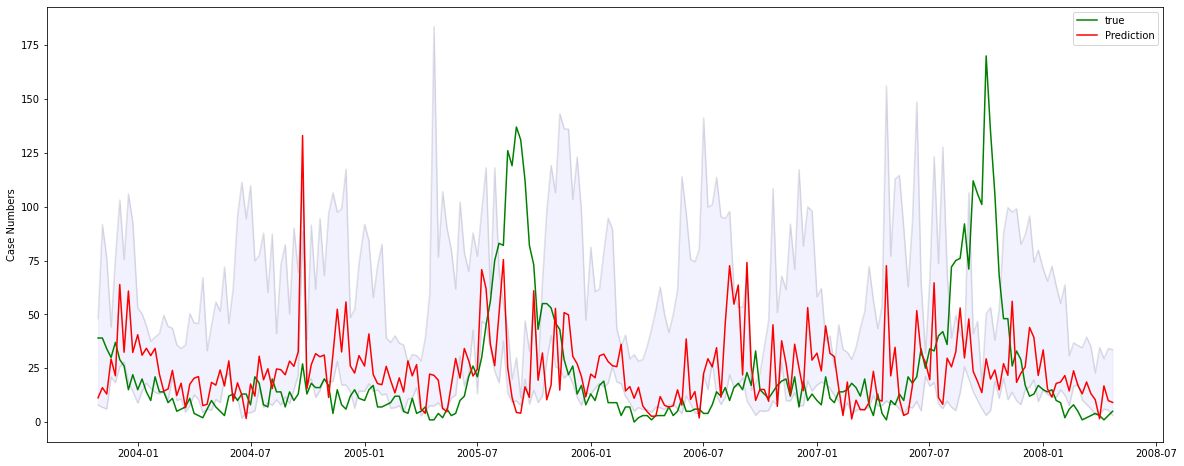

In [27]:
fig = plt.figure(figsize=(20, 8))
plt.plot(sj_Ytest, c= 'g', label= 'true')
plt.plot(sj_Ytest.index, yhat, 'r', label='Prediction')
plt.plot(sj_Ytest.index, y_upper, 'k', alpha= 0.1)
plt.plot(sj_Ytest.index, y_lower, 'k', alpha= 0.1)
plt.fill_between(sj_Ytest.index, y_lower, y_upper, color= 'b', alpha= 0.05)
plt.ylabel('Case Numbers')
plt.legend()
getscores(sj_Ytest, yhat)

The model is overpredicting for almost all weeks except for the last outbreak period. The higher overall trend in predictions as well as the high volitility in the pattern may benifit from reducing feature space the model is trying to learn.

In [28]:
# RFE to find feature subset that reduces the RMSE loss
sj_gbrSelector = GradientBoostingRegressor(random_state= 1, **sj_gbr_grid)
sj_RFE = RFECV(sj_gbrSelector, cv= tscv, n_jobs= -1)
sj_RFE.fit(sj_XtrainRolled, sj_ytrain_sqrt.values.ravel())
sj_RFE_features = sj_XtrainRolled.columns[sj_RFE.support_]
# sj_RFE_features

In [29]:
sj_gbrRFE = GradientBoostingRegressor(loss= 'quantile', alpha= alpha,  random_state= 1, **sj_gbr_grid)
sj_gbrRFE.fit(sj_XtrainRolled[sj_RFE_features], sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
y_upperRFE = sj_gbrRFE.predict(sj_XtestRolled[sj_RFE_features]) **2

sj_gbrRFE.set_params(alpha = 1. - alpha)
sj_gbrRFE.fit(sj_XtrainRolled[sj_RFE_features], sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
y_lowerRFE = sj_gbrRFE.predict(sj_XtestRolled[sj_RFE_features])**2

sj_gbrRFE.set_params(loss= 'ls')
sj_gbrRFE.fit(sj_XtrainRolled[sj_RFE_features], sj_ytrain_sqrt.values.ravel(), sample_weight= sj_ytrain_sqrt_weight.values.ravel())
yhatRFE = sj_gbrRFE.predict(sj_XtestRolled[sj_RFE_features])**2

{'MAE': 21.09720133171458,
 'SMAPE': 0.4252455952468121,
 'RMSE': 32.10759902425585}

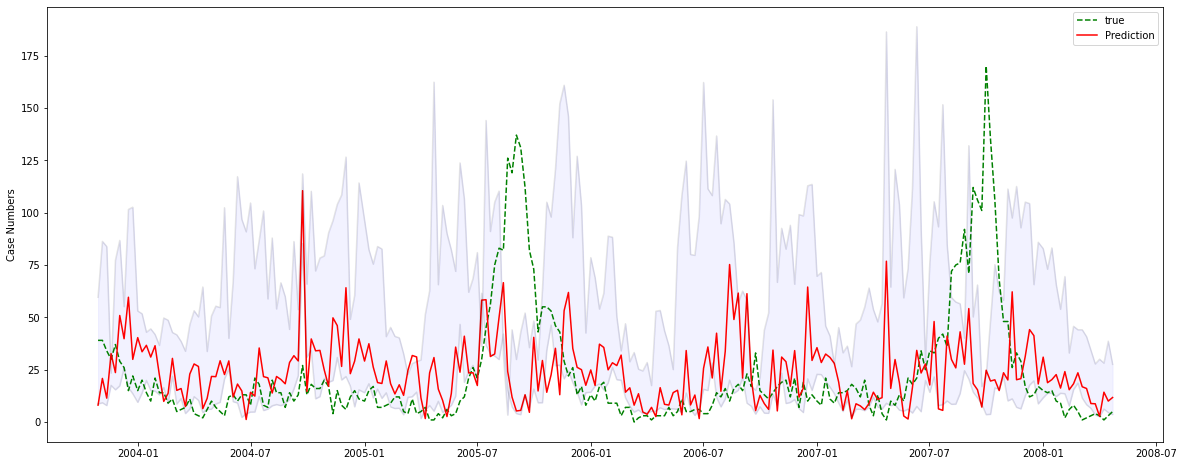

In [30]:
fig = plt.figure(figsize=(20, 8))
plt.plot(sj_Ytest, c= 'g', ls= '--', label= 'true')
plt.plot(sj_Ytest.index, yhatRFE, 'r-', label='Prediction')
plt.plot(sj_Ytest.index, y_upperRFE, 'k-', alpha= 0.1)
plt.plot(sj_Ytest.index, y_lowerRFE, 'k-', alpha= 0.1)
plt.fill_between(sj_Ytest.index, y_lowerRFE, y_upperRFE, color= 'b', alpha= 0.05)
plt.ylabel('Case Numbers')
plt.legend()
getscores(sj_Ytest, yhatRFE)

# XGBOOST

In [31]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [32]:
one_to_left = stats.beta(10, 1)
from_zero_positive = stats.expon(0, 50)

In [46]:
# xgbR_grid = {
#     "n_estimators": stats.randint(3, 400),
#     "max_depth": stats.randint(3, 40),
#     "learning_rate": stats.uniform(0.01, 0.1),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": stats.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive}

# # IQ
# iq_xgr = XGBRegressor()
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, scoring= 'neg_mean_squared_error', 
#                          n_jobs= -1, n_iter= 50, random_state= 1)
# rsx.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# rsx.best_params_

{'colsample_bytree': 0.9986220713654419,
 'gamma': 0.7002214371922233,
 'learning_rate': 0.058634511093703184,
 'max_depth': 18,
 'min_child_weight': 71.89478191847827,
 'n_estimators': 90,
 'reg_alpha': 19.089558708920645,
 'subsample': 0.9269148834786443}

In [47]:
# sj_xgr = XGBRegressor()
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, scoring= 'neg_mean_squared_error', 
#                          n_jobs= -1, n_iter= 50, random_state= 1)
# rsx.fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# rsx.best_params_

{'colsample_bytree': 0.9987547245408968,
 'gamma': 5.38627282576347,
 'learning_rate': 0.010301795661959637,
 'max_depth': 24,
 'min_child_weight': 74.85339251647828,
 'n_estimators': 95,
 'reg_alpha': 79.47366244819447,
 'subsample': 0.9855218877187018}

In [33]:
sj_xg_grid = {'colsample_bytree': 0.9987547245408968,
                'gamma': 5.38627282576347,
                'learning_rate': 0.010301795661959637,
                'max_depth': 24,
                'min_child_weight': 74.85339251647828,
                'n_estimators': 95,
                'reg_alpha': 79.47366244819447,
                'subsample': 0.9855218877187018}

sj_xgr = XGBRegressor(**sj_xg_grid)
sj_xgr.fit(sj_XtrainRolled, sj_Ytrain)
sj_x_pred = sj_xgr.predict(sj_XtestRolled)

In [34]:
iq_xg_grid = {'colsample_bytree': 0.9986220713654419,
              'gamma': 0.7002214371922233,
              'learning_rate': 0.058634511093703184,
              'max_depth': 18,
              'min_child_weight': 71.89478191847827,
              'n_estimators': 90,
              'reg_alpha': 19.089558708920645,
              'subsample': 0.9269148834786443}

iq_xgr = XGBRegressor(**iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled, iq_Ytrain)
iq_x_pred = iq_xgr.predict(iq_XtestRolled)

In [527]:
iq_xgr.fit(iq_XtrainRolled, iq_Ytrain)
i = iq_xgr.predict(iq_XtestRolled)

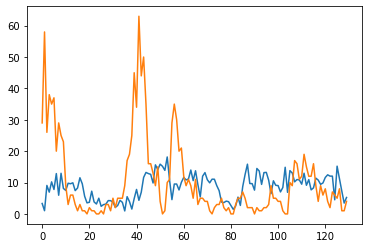

In [532]:
plt.plot(iq_x_pred)
plt.plot(range(iq_Ytest.size), iq_Ytest)

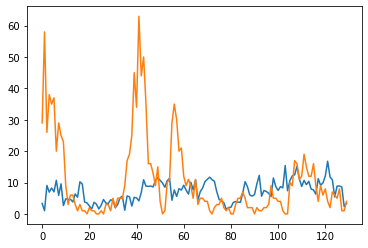

In [531]:
plt.plot(i)
plt.plot(range(iq_Ytest.size), iq_Ytest)

In [514]:
# SJ
# sj_xgr = XGBRegressor()
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, scoring= 'neg_mean_squared_error',
#                          n_jobs= -1, n_iter= 50, random_state= 1)
# rsx.fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# rsx.best_params_

{'colsample_bytree': 0.9987547245408968,
 'gamma': 5.38627282576347,
 'learning_rate': 0.010301795661959637,
 'max_depth': 24,
 'min_child_weight': 74.85339251647828,
 'n_estimators': 95,
 'reg_alpha': 79.47366244819447,
 'subsample': 0.9855218877187018}

In [520]:
sj_xg_grid = {'colsample_bytree': 0.9987547245408968,
              'gamma': 5.38627282576347,
              'learning_rate': 0.010301795661959637,
              'max_depth': 24,
              'min_child_weight': 74.85339251647828,
              'n_estimators': 95,
              'reg_alpha': 79.47366244819447,
              'subsample': 0.9855218877187018}

sj_xgr = XGBRegressor(**sj_xg_grid)

# ExtraTreesRegressor

In [12]:
# Plotting funciton for the Extra trees models
def plot_et(ytest, ypred1, ypred2=None, city='iq', y1label="", y2label="", flair="", rolled= False):
    
    y2= False if ypred2 is None else True
    
    if city == 'iq':
        yidx = iq_Ytest.index.copy()
        title = 'Iquitos'+flair
    elif city== 'sj':
        yidx = sj_Ytest.index.copy()
        title = 'San Juan'+flair
        
    ax = plt.figure(figsize=(16,6)).add_subplot()
    if rolled is False:
        ax.plot(yidx, ypred1, c='g', lw= 2, alpha= 0.6, label= '{:s}'.format(y1label))
        if y2:
            ax.plot(yidx, ypred2, c= 'b', lw= 2, alpha= 0.6, label = '{:s}'.format(y2label))
        ax.plot(yidx, ytest, c= 'r', label='True Values')
        ax.set_title('{:s} ExtraTrees Predictions'.format(title), size=20)
        
    else:
        ax.plot(yidx[2:], ypred1, c='g', lw= 2, alpha= 0.6, label= '{:s}'.format(y1label))
        if y2:
            ax.plot(yidx[2:], ypred2, c= 'b', lw= 2, alpha= 0.6, label = '{:s}'.format(y2label))
        ax.plot(yidx[2:], ytest, c= 'r', label='True Values')
        ax.set_title('Rolling {:s} ExtraTrees Predictions'.format(title), size=20)
        
    plt.xticks(rotation= 60, size=15)
    ax.legend()
    plt.xticks(rotation= 60, size=15)
    ax.set_ylim(0);

## Iquitos Extra Trees

In [13]:
# # GridSearchCV with ExtraTreesRegression estimator
# iq_etGrid = {"max_depth": [1, 2, 5, 10, 15, 20, 35],
#             "min_samples_leaf": [1, 2, 5, 10, 20, 35, np.arange(50, 101, 10)]}

# iq_et = ExtraTreesRegressor(random_state= 1) 
# gs = GridSearchCV(estimator= iq_et, param_grid= iq_etGrid, scoring=rmsle_scorer, n_jobs= -1)
# gs.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
# gs.best_params_

{'max_depth': 1, 'min_samples_leaf': 35}

In [14]:
# Best params found by Gridsearch using all features
iq_etGrid = {"max_depth": 1,
            "min_samples_leaf": 35}  

#Predicting full length of test set
iq_et = ExtraTreesRegressor(**iq_etGrid, random_state= 1)
iq_et.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
iq_et_pred = iq_et.predict(iq_XtestRolled)

#using above defined stepwise function to predict and refit 4 weeks at a time
iq_et_s = ExtraTreesRegressor(**iq_etGrid, random_state= 1)
iq_et_s_pred = steptesting(iq_XtrainRolled, 
                           iq_Ytrain,
                           iq_XtestRolled, 
                           iq_Ytest, 
                           iq_et_s)

Iquitos ExtraTrees metrics(full):
{'MAE': 8.019647744585654, 'SMAPE': 0.4398896878959282, 'RMSLE': 1.0961839629513892}

Iquitos ExtraTrees metrics(step):
{'MAE': 8.310537469918652, 'SMAPE': 0.44963553070153006, 'RMSLE': 1.1183384844254505}


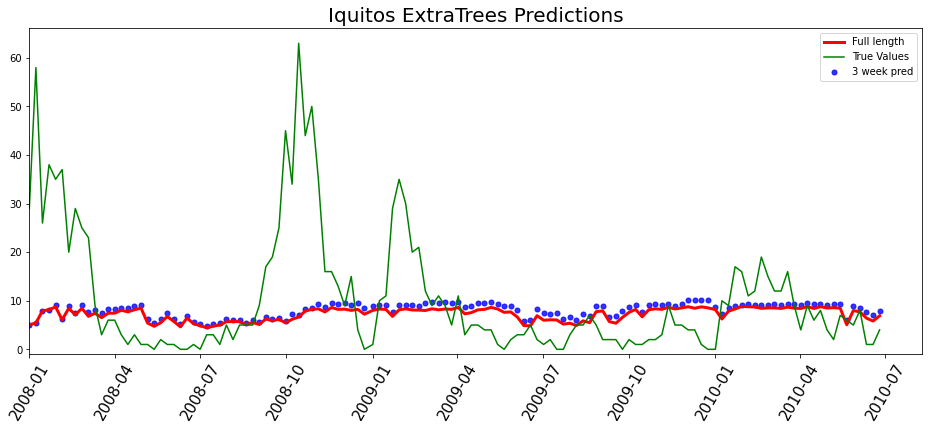

In [15]:
# Plot results
plot_et(iq_Ytest, iq_et_pred, iq_et_s_pred, y1label= 'Full length', y2label= '4 week pred')
print('Iquitos ExtraTrees metrics(full):')
display(getscores(iq_Ytest, iq_et_pred))
print('\nIquitos ExtraTrees metrics(step):')
display(getscores(iq_Ytest, iq_et_s_pred))

In [ ]:
# As we are predicting 4 weeks at a time, we can look at the model performance in a 4 week rolling window.
iq_baseET_roll = roll_cases(iq_et_pred, window= 4)
iq_baseET_step_roll = roll_cases(iq_et_s_pred, window= 4)
iq_Ytest_roll = roll_cases(iq_Ytest, window= 4)

plot_et(iq_Ytest_roll, iq_baseET_roll, iq_baseET_step_roll,
           y1label= 'Full length', y2label= '4 week pred',
          rolled= True)
print('Rolling Iquitos metrics(full):')
display(getscores(iq_Ytest_roll, iq_baseET_roll, iq_XtestRolled))
print('\nRolling Iquitos  metrics(step):')
display(getscores(iq_Ytest_roll, iq_baseET_step_roll, iq_XtestRolled))

### Recursive Feature Elimination

<br>

* RFE can help to bring out the more important features, increasing prediction power.

In [16]:
iq_estimator = ExtraTreesRegressor(**iq_etGrid, random_state= 1)
iq_selector = RFECV(iq_estimator, scoring= rmsle_scorer, n_jobs= -1)
iq_selector = iq_selector.fit(iq_XtrainRolled, iq_Ytrain.to_numpy().ravel())
iq_etRFE_features = iq_XtrainRolled.columns[iq_selector.get_support()]
# [print(i) for i in iq_etRFE_features][0]
iq_etRFE_features.size

33

In [17]:
# # GridSearch using RFE selected features
# iq_etRFE_grid = {"max_depth": [1, 2, 5, 10, 15, 20], 
#             "min_samples_leaf": [1, 2, 5, 10, 15, 20, 35, *np.arange(50, 101, 10)]}

# iq_et_rfe = ExtraTreesRegressor(random_state= 1)
# gs = GridSearchCV(estimator= iq_et_rfe, param_grid= iq_etRFE_grid, scoring= rmsle_scorer, n_jobs= -1)
# gs.fit(iq_XtrainRolled[iq_etRFE_features], iq_Ytrain.to_numpy().ravel())
# gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 70}

In [18]:
# RFE selected features
iq_etRFE_grid = {"max_depth": 5, 
            "min_samples_leaf": 70}

iq_etRFE_full = ExtraTreesRegressor(**iq_etRFE_grid, random_state= 1, n_jobs= -1)
iq_etRFE_full.fit(iq_XtrainRolled[iq_etRFE_features], iq_Ytrain.to_numpy().ravel())
iq_etRFE_full_pred = iq_etRFE_full.predict(iq_XtestRolled[iq_etRFE_features])

iq_etRFE_step = ExtraTreesRegressor(**iq_etRFE_grid, random_state= 1, n_jobs= -1)
iq_etRFE_step_pred = steptesting(iq_XtrainRolled[iq_etRFE_features],
                            iq_Ytrain, 
                            iq_XtestRolled[iq_etRFE_features],
                            iq_Ytest, 
                            iq_etRFE_step)

Iquitos ET RFE(Full):
{'MAE': 7.921553121373193, 'SMAPE': 0.4351049362090589, 'RMSLE': 1.1133153105210052}

Iquitos ET RFE(Step):
{'MAE': 8.265720108897826, 'SMAPE': 0.44417644235650267, 'RMSLE': 1.1406854993918085}

Iquitos ET All features(full):
{'MAE': 8.019647744585654, 'SMAPE': 0.4398896878959282, 'RMSLE': 1.0961839629513892}


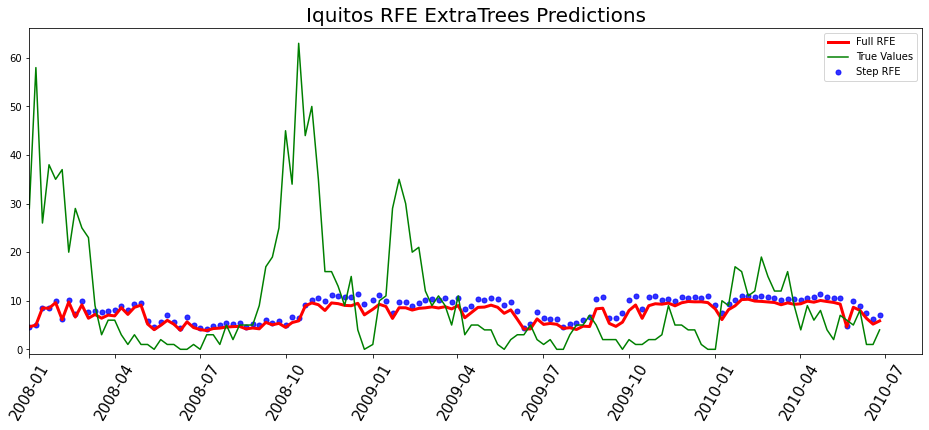

In [19]:
plot_et(iq_Ytest, iq_etRFE_full_pred, iq_etRFE_step_pred, y1label='Full RFE', 
        y2label='Step RFE', flair=" RFE")

print('Iquitos ET RFE(Full):')
print(getscores(iq_Ytest, iq_etRFE_full_pred))
print('\nIquitos ET RFE(Step):')
print(getscores(iq_Ytest, iq_etRFE_step_pred))
print('\nIquitos ET All features(full):')
print(getscores(iq_Ytest, iq_et_pred))

* It seems Iquitos, for the ExtraTrees model, got worse by selecting a subset of features with RFE. I've tried many, many features and different scoring metrics, but the results were about the same.


* Also notice that the stepwise predictions are statistically slightly worse than predicting the full length of the test set in one go. 

In [75]:
# 4 week rolling predictions with RFE
iq_rfeET_roll = roll_cases(iq_et_RFE_pred, window= 4)

plot_et(iq_Ytest_roll, iq_rfeET_roll, iq_baseET_step_roll, y1label="RFE", 
        y2label='All ind. vars', flair='RFE', rolled= True)

print('Rolling Iquitos metrics(RFE):')
getscores(iq_Ytest_roll, iq_rfeET_roll)
print('\nRolling Iquitos  metrics(step):')
getscores(iq_Ytest_roll, iq_baseET_step_roll)

## San Juan Extra Trees Regression:

In [20]:
# # GridSeach using all features for San Juan
# sj_etGrid = {"max_depth": [1, 2, 5, 10, 15],
#               "min_samples_leaf": [1, 2, 5, 10, 15, 35, *np.arange(50, 101, 10)]}

# sj_et = ExtraTreesRegressor(random_state= 1)
# gs = GridSearchCV(estimator= sj_et, param_grid= sj_etGrid, scoring=rmsle_scorer, n_jobs= -1)
# gs.fit(sj_XtrainRolled, sj_Ytrain.to_numpy().ravel())
# gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

In [21]:
# GridSearchCV optimal parameters found for San Juan ExtraTreesRegressor with all features
sj_etGrid = {'max_depth': 10, 
             'min_samples_leaf': 10}

# Full ExtraTrees prediction for San Juan for comparison
sj_et_full = ExtraTreesRegressor(**sj_etGrid, random_state= 1, n_jobs= 1)
sj_et_full.fit(sj_XtrainRolled, sj_Ytrain.to_numpy().ravel())
sj_et_full_pred = sj_et_full.predict(sj_XtestRolled)

# Stepwise prediction
sj_et_step = ExtraTreesRegressor(**sj_etGrid, random_state= 1, n_jobs= -1)
sj_et_step_pred = steptesting(sj_XtrainRolled, sj_Ytrain, sj_XtestRolled, sj_Ytest, sj_et_step)

In [ ]:
# Plot San Juan all features
plot_et(sj_Ytest, sj_et_pred, sj_et_step_pred, y1label='Full length', y2label='4 week', city='sj')

# There is a larger amount of test data for San Juan, we'll look at 2005 outbreak for a closer look
sj_2005slice = sj_Ytest.index.get_loc('2005')
sj_indx2005 = sj_Ytest.index[sj_2005slice]
sj_vals2005_full = sj_et_pred[sj_2005slice]
sj_vals2005_step = sj_et_step_pred[sj_2005slice]

ax1 = plt.figure().add_subplot()
ax1.plot(sj_indx2005, sj_vals2005_full, c='g', lw= 2, alpha= 0.8, label= 'Predictions')
ax1.plot(sj_indx2005, sj_vals2005_step, c='b', lw= 2, alpha= 0.8, label= 'Predictions (step)')
ax1.plot(sj_indx2005, sj_Ytest.loc[sj_indx2005], c= 'r', lw= 2, label='True Values')
ax1.legend(loc='upper left')
plt.title('San Juan 2005 predictions (All features)', size= 15)
plt.xticks([sj_indx2005[0], sj_indx2005.mean(), sj_indx2005[-1]],
           [sj_indx2005[0].month_name(), sj_indx2005.mean().month_name(), sj_indx2005[-1].month_name()],
          size= 15)
plt.yticks(size= 10)
plt.ylim(0)

# metrics
print('San Juan ExtraTrees metrics')
display(getscores(sj_Ytest, sj_et_pred, sj_Ytest))
print('\nSan Juan ExtraTrees metrics(step)')
display(getscores(sj_Ytest, sj_et_step_pred, sj_Ytest))

San Juan ET Full Length metrics:
{'MAE': 22.38260441705872, 'SMAPE': 0.42874104131251917, 'RMSLE': 1.3512344867290955}

San Juan ET Step Prediction metrics:
{'MAE': 20.985868314234278, 'SMAPE': 0.4072086252778756, 'RMSLE': 1.2969740223534296}


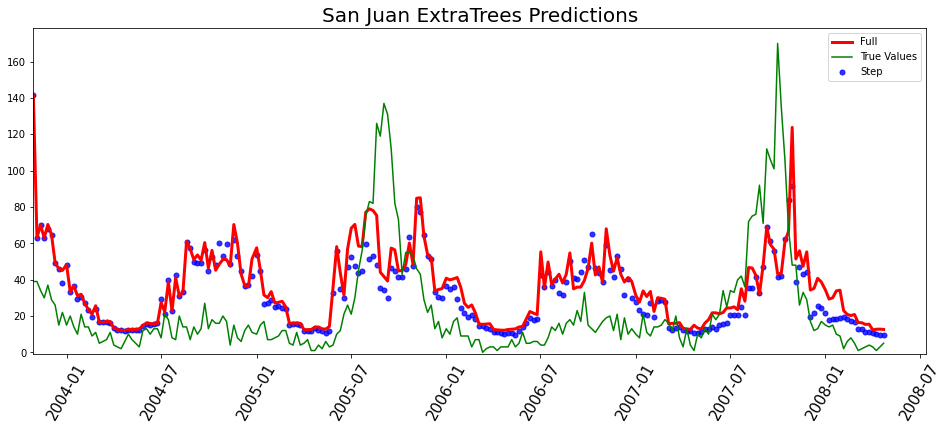

In [22]:
plot_et(sj_Ytest, sj_et_full_pred, sj_et_step_pred, y1label='Full', y2label= 'Step', city='sj')
print('San Juan ET Full Length metrics:')
print(getscores(sj_Ytest, sj_et_full_pred))
print('\nSan Juan ET Step Prediction metrics:')
print(getscores(sj_Ytest, sj_et_step_pred))

In [ ]:
# Rolling predictions for San Juan, 4 week rolling window
sj_baseET_roll = roll_cases(sj_et_pred)
sj_baseET_step_roll = roll_cases(sj_et_step_pred)
sj_Ytest_roll = roll_cases(sj_Ytest)

plot_et(sj_Ytest_roll, sj_baseET_roll, sj_baseET_step_roll, y1label=" RFE", 
        y2label='All ind. vars', city='sj', flair=' RFE', rolled= True)

print('Rolling San Juan metrics(full):')
getscores(sj_Ytest_roll, sj_baseET_roll)
print('\nRolling San Juan  metrics(step):')
getscores(sj_Ytest_roll, sj_baseET_step_roll)

In [24]:
# RFECV feature selection for San Juan, ExtraTreesRegressor estimator
sj_estimator = ExtraTreesRegressor(**sj_etGrid, random_state= 1)
sj_selector = RFECV(sj_estimator, scoring= rmsle_scorer, n_jobs= -1)
sj_selector = sj_selector.fit(sj_XtrainRolled, sj_Ytrain.to_numpy().ravel())
sj_etRFE_features = sj_XtrainRolled.columns[sj_selector.get_support()]
# [print(i) for i in sj_etRFE_features][0]
sj_etRFE_features.size

44

As expected, both chose `tempurature`, `humidity`, and `precipitation` features, but RFE selected `NDVI` vegetation and `month` features on top. This could be due to the larger amount of data available for San Juan, but RFE didn't choose a single month as important for predicting cases in Iquitos - though we see that it doesn't do a good job of doing that.

* Dropped months*

In [25]:
# # GridSearch with RFE feature subset
# sj_etRFE_grid = {"max_depth": [1, 2, 5, 10, 15, 20, 35],
#                  "min_samples_leaf": [1, 2, 5, 10, 15, 20, 35]}

# sj_etRFE = ExtraTreesRegressor(random_state= 1)
# gs = GridSearchCV(estimator= sj_etRFE, param_grid= sj_etRFE_grid, scoring= rmsle_scorer, n_jobs= -1)
# gs.fit(sj_XtrainRolled[sj_etRFE_features], sj_Ytrain.values.ravel())
# gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [26]:
# optimal parameters found for RFE feature subset
sj_etRFE_grid = {"max_depth": 10,
            "min_samples_leaf": 5}

sj_etRFE_full = ExtraTreesRegressor(**sj_etRFE_grid, random_state= 1, n_jobs= -1)
sj_etRFE_full.fit(sj_XtrainRolled[sj_etRFE_features], sj_Ytrain.to_numpy().ravel())
sj_etRFE_full_pred = sj_etRFE_full.predict(sj_XtestRolled[sj_etRFE_features])

sj_etRFE_step = ExtraTreesRegressor(**sj_etRFE_grid, random_state= 1, n_jobs= -1)
sj_etRFE_step_pred = steptesting(sj_XtrainRolled[sj_etRFE_features],
                         sj_Ytrain,
                         sj_XtestRolled[sj_etRFE_features],
                         sj_Ytest,
                         sj_etRFE_step)

San Juan ET RFE(Full):
{'MAE': 22.69439835374929, 'SMAPE': 0.42874647254761306, 'RMSLE': 1.3444812675416389}

San Juan ET RFE(Step):
{'MAE': 20.907822378406596, 'SMAPE': 0.40506005824324376, 'RMSLE': 1.2927625500348192}

San Juan ET All Features(Step):
{'MAE': 20.985868314234278, 'SMAPE': 0.4072086252778756, 'RMSLE': 1.2969740223534296}


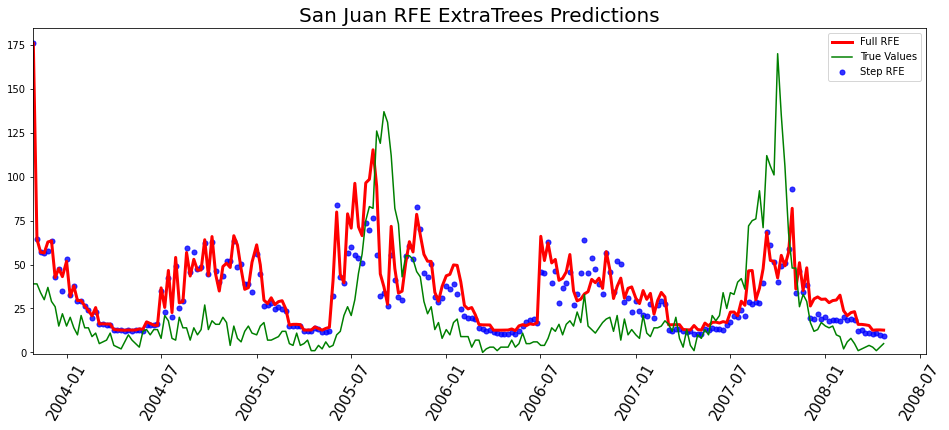

In [27]:
plot_et(sj_Ytest, sj_etRFE_full_pred, sj_etRFE_step_pred, y1label='Full RFE', 
        y2label='Step RFE', flair=' RFE', city='sj')
print('San Juan ET RFE(Full):')
print(getscores(sj_Ytest, sj_etRFE_full_pred))
print('\nSan Juan ET RFE(Step):')
print(getscores(sj_Ytest, sj_etRFE_step_pred))
print('\nSan Juan ET All Features(Step):')
print(getscores(sj_Ytest, sj_et_step_pred))

Although the two cities chose different numbers of features after RFE, neither model predictions improved by a noticable amount. For the San Juan model, the metrics were actually worse with the reduced feature set than the step prediction using all features.
* Though slight, it seems the San Juan model is slightly better with the stepwise predictions than the Iquitos model is.

There appears to be some sort of seasonal pattern to the predictions in San Juan as well, though these predictions are far over what the true case numbers are. Iquitos seems to be the exact opposite, there is not seasonal trend that appears, and it is certainly not overpredicting the case numbers. From the EDA, that can be expected, as San Juan seemed to have a more regular pattern of case numbers throughout the year while Iquitos had a weaker correlation between the time of year and case numbers.


This seasonal trend does seem to line up with the seasons of higher cases, though it isn't consistant in the case numbers year after year either.

## ExtraTrees summary

* There are very different results from the ExtraTreesRegression models between the cities. The Iquitos model seems hardly influenced by  the features at all. There are small increases and decreases in the otherwise fairly flat prediction baseline when case numbers change, though these predictions still don't align with the true case numbers. Using a subset of features, to try and use only the features that are important in prediction and removing the features that aren't important and can get in the way of accuracy, there is next to no change in predictions. It doesn't seem that this model would be a good method of predicting case numbers, for Iquitos as least.


* The San Juan model seems to be the flip side of the coin. It over-predicts for all time periods except for the outbreaks. There seems to be some form of annual cycle that appers in our predictions, and interestingly, these jumps in predictions by the model sync with the time periods where San Juan experienced increases in dengue case numbers. Unfortunatley, the predictions overall are higher than true case numbers and the increases are not of the same magnitude as their corresponding true values for the week.


* As expected, the important features found by RFE for each city include tempurature, humidity, precipitation, and some time (month) features. RFE found that month values are more important for San Juan than for Iquitos, by including the full year rather than just months of high case numbers.

# SVM

### Scaling to preprocess for SVM

In [ ]:
from sklearn.preprocessing import StandardScaler

In [73]:
# SVR is distance based, we need to standardize to zero-mean, unit variance
# >> Months are binary, those won't need to be scaled
# dont_scale = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# to_scale = list(set(iq_XtrainRolled.columns).difference(dont_scale))


# IQ
iq_scaler = StandardScaler()

iq_trainScaled = iq_scaler.fit_transform(iq_XtrainRolled)#[to_scale])
iq_testScaled = iq_scaler.transform(iq_XtestRolled)

#not a necessity, nicer to look at
# iq_XtrainScaled = iq_XtrainRolled[dont_scale].reindex(['Jan', 'Feb', 'Mar',
#                                                 'Apr', 'May', 'Jun', 'Jun', 'Jul',
#                                                 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], axis=1)

#iq_XtrainScaled = iq_XtrainRolled[dont_scale].merge()
iq_XtrainScaled = pd.DataFrame(iq_trainScaled, index= iq_Xtrain.index, columns= iq_XtrainRolled.columns)
iq_XtestScaled = pd.DataFrame(iq_testScaled, index= iq_Xtest.index, columns= iq_XtestRolled.columns)

NameError: name 'StandardScaler' is not defined

In [ ]:
iq_svrGrid = {'C' : [1e0, 1e1, 1e2],
              'epsilon': np.logspace(-3, 2, 6)}

iq_svr = SVR(kernel='linear', cache_size=1000)
gs = GridSearchCV(estimator= iq_svr, param_grid= iq_svrGrid, cv=tscv, scoring= 'neg_root_mean_squared_error')
gs.fit(iq_XtrainScaled, iq_Ytrain.values.ravel())
gs.best_params_

In [ ]:
lin_iq_pred = steptesting(iq_XtrainScaled, iq_Ytrain, iq_XtestScaled, iq_Ytest, gs.best_estimator_)
ax = plt.figure(figsize=(16,6)).add_subplot()
ax.plot(iq_Ytest.index, lin_iq_pred, c='g', lw= 2, label= 'Predictions')
ax.plot(iq_Ytest.index, iq_Ytest, c= 'r', lw= 2, label='True Values')
plt.legend()
plt.title('Iquitos SVR(linear) Prediction', size= 20)
plt.ylabel('Case numbers', size= 15)
plt.xticks(rotation=60, size= 15)
plt.ylim(0)
getscores(iq_Ytest, lin_iq_pred)

In [ ]:
# iq_svrGrid = {'C' : [1e0, 1e1, 1e2],
#               'epsilon': np.logspace(-3, 2, 6),
#              'gamma': np.logspace(-7, -2, 6)}

# iq_svrRBF = SVR(kernel='rbf', cache_size=1000)
# gs = GridSearchCV(estimator= iq_svrRBF, param_grid= iq_svrGrid, cv=tscv, scoring= 'neg_root_mean_squared_error')
# gs.fit(iq_XtrainScaled, iq_Ytrain.values.ravel())
# gs.best_params_

In [ ]:
iq_svrGrid = {'C': 100.0, 'epsilon': 1.0, 'gamma': 1e-05}

iq_svrRBF = SVR(kernel='rbf', **iq_svrGrid)
iq_svrRBF_pred = steptesting(iq_XtrainScaled, iq_Ytrain,
                   iq_XtestScaled, iq_Ytest, iq_svrRBF)

ax = plt.figure(figsize=(16,6)).add_subplot()
ax.plot(iq_Ytest.index, iq_svrRBF_pred, c='g', lw= 2, label= 'Predictions')
ax.plot(iq_Ytest, c= 'r', lw= 2, label='True Values')
plt.legend()
plt.title('Iquitos SVR(rbf) Prediction', size= 20)
plt.ylabel('Case numbers', size= 15)
plt.xticks(rotation=60, size= 15)
plt.ylim(0)
getscores(iq_Ytest, iq_svr_pred)

### San Juan

In [ ]:
sj_scaler = StandardScaler()
sj_trainScaled = sj_scaler.fit_transform(sj_XtrainRolled)#[to_scale])
sj_testScaled = sj_scaler.transform(sj_XtestRolled)
# sj_XtrainScaled = sj_XtrainRolled[not_to_scale].reindex(['percent_change',
#                                     'week_avg_cases', 'prev_week', 'Jan', 'Feb',
#                                     'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
#                                     'Sep', 'Oct', 'Nov', 'Dec'], axis=1)

# sj_XtrainScaled = sj_XtrainScaled.merge(pd.DataFrame(sj_trainScaled, index= sj_XtrainRolled.index, columns= to_scale),left_index=True, right_index=True)
sj_XtrainScaled = pd.DataFrame(sj_trainScaled, index= sj_XtrainRolled.index, columns= sj_XtrainRolled.columns)
sj_XtestScaled = pd.DataFrame(sj_testScaled, index= sj_XtestRolled.index, columns= sj_XtestRolled.columns)

In [ ]:
sj_svrGrid = {'C' : np.logspace(0, 5, 6),
             'epsilon':  np.logspace(-6, 2, 9),
             'gamma':np.logspace(-8, 0, 9)}

sj_svr = SVR(kernel= 'rbf')
gs = GridSearchCV(estimator= sj_svr, param_grid= sj_svrGrid, cv= tscv, scoring= ['neg_root_mean_squared_error', 'r2'], refit= 'neg_root_mean_squared_error')
gs.fit(sj_XtrainScaled, sj_Ytrain.values.ravel())
gs.best_params_

In [ ]:
sj_svrGrid = {'C': 10000.0,
             'epsilon':  1e-04,
             'gamma': 1e-05}

sj_svr = SVR(kernel= 'rbf', **sj_svrGrid)
sj_svr_pred =  steptesting(sj_XtrainScaled, sj_Ytrain, sj_XtestScaled, sj_Ytest, sj_svr)

ax = plt.figure(figsize=(16, 6)).add_subplot()
ax.plot(sj_Ytest.index, sj_svr_pred, c='g', lw= 2, label= 'Predictions')
ax.plot(sj_Ytest.index, sj_Ytest, c= 'r', lw= 2, label='True Values')
plt.legend()
plt.title('San Juan SVR(rbf) Prediction', size= 20)
plt.ylabel('Case numbers', size= 15)
plt.xticks(rotation= 60, size= 15)
plt.ylim(0)
getscores(sj_Ytest, sj_svr_pred)

<br>